# TP2 : Extraction d'informations

Sur la base des éléments méthodologiques et des enseignements techniques présentés lors du cours théorique, il est demandé dans le cadre de ce TP :
- de se familiariser avec les techniques d’enrichissement (extraction de mots-clés, reconnaissance d’entités nommées, analyse de sentiment...)
- d’appliquer celles-ci au corpus de bulletins de la ville de Bruxelles préalablement convertis au format .txt

Pour ce faire, vous utiliserez différentes librairies Python vues au cours.

## 1. Keywords

### Librairies utilisées dans le code

#### Choix d'une année à analyser

In [1]:
import os
from collections import defaultdict, Counter
import textract
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import yake
from wordcloud import WordCloud
from IPython.display import Image
import sys
import spacy 
from spacy.lang.fr.examples import sentences
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Sélection des fichiers à analyser

#### Choix d'une année à analyser

In [2]:
selected_year = 1930

#### Stocker la liste des fichiers contenus dans le dossier 'txt'

In [3]:
txt_path = "../data/txt/"
files = sorted(os.listdir(txt_path))
len(files)

2827

#### Lister les fichiers pour Bruxelles et pour Laeken

In [4]:
bxl_selected_year = [f for f in files if f.startswith('Bxl_') and str(selected_year) in f]
print(len(bxl_selected_year))

lkn_selected_year = [f for f in files if f.startswith('Lkn_') and str(selected_year) in f]
print(len(lkn_selected_year))

31
0


#### Vérification du nombre de fichiers

In [5]:
count_years = defaultdict(int)

for f in files: 
    if "_" in f and f.endswith("txt"): 
        elems = f.split("_") 
        year = elems[1] 
        count_years[year] += 1 
        
n_selected_year = count_years[str(selected_year)]
print(n_selected_year)

31


### Récupérer le texte des fichiers

#### Créer le dossier adéquat

In [6]:
path_year = os.path.join('../data/', str(selected_year))
if not os.path.exists(path_year):
    os.mkdir(path_year)

#### Copier les fichiers désirés dans le dossier

In [7]:
for txt in bxl_selected_year:
    text = textract.process(os.path.join(txt_path, txt))
    with open(os.path.join(path_year, txt), 'wb') as f: 
        f.write(text) 

#### Concaténer le texte des fichiers

In [8]:
!cat ../data/{selected_year}/*.txt > ../data/{selected_year}.txt

#### Compter le nombre de mots repris dans le fichier

In [9]:
!wc -m ../data/{selected_year}.txt

4474200 ../data/1930.txt


#### Vérification du nombre de mots

In [10]:
text_selected = open(os.path.join(f'../data/{selected_year}.txt'), 'r').read()
print(len(text_selected))

4474200


#### Affichage des premiers caractères

In [11]:
text_selected[:500]

'VILLE\n\nDE\n\nBRUXELLES\n\nBULLETIN COMMUNAL\nA N N É E\n\n1930\n\nTOME\n\nII\n\nBRUXELLES\nIMPRIMERIE\n\nE . G U Y O T , S. A.\n\n12. rue Pachéco, 12\n1 930\n\n\x0c\x0cN" l .\n\nCOMTTE RENDU DE LA SÉANCE DU 7 JUILLET IfWO.\n\nV I L L E\n\nD E\n\nBULLETIN\nAnnée\n\nC O N S E I L\nSéance\n\nB R U X E L L E S\n\nGO M M U N AI\n1930.\n\nC O M M U N A L\n\ndu 7 Juillet\n\n1930.\n\nPrésidence de M . ADOLPHE M A X , Bourgmestre.\n\nSOMMAIRE :\nPAGES.\n\n1.\n2.\n3.\n\nCommunications\n. . .\n5\nDémission de M. l\'Echevin Jacqmain\n20\nElection et prestation de serment d'

### Extraction des mots clés

#### Extraire les mots clés pour l'année entière

In [12]:
text_all = open(os.path.join(f'../data/{selected_year}.txt'), 'r').read()

In [13]:
ignored = ["conseil communal", "conseil général", "conseiller communal", "rue rue", "avenue rue", "maison rue"]

In [14]:
kw_extractor = yake.KeywordExtractor(lan="fr", top=100)
keywords = kw_extractor.extract_keywords(text_all.lower())

kw_results = []
unigr = []
for kw, score in keywords:
    kword = kw.split()
    if len(kword) == 2 and kw.lower() not in ignored:
        kw_results.append(kw.lower())
    if len(kword) == 1 and kw.lower() not in ignored:
        unigr.append(kw.lower())

print(sorted(set(kw_results)))

['avis favorable', 'comité scolaire', "commission d'assistance", 'crédit communal', 'crédits supplémentaires', "d'assistance publique", "d'un crédit", "d'un service", "frais d'administration", "frais d'entretien", "l'année scolaire", "l'echevin van", 'pensions communales', 'rue haute', 'rue van', 'service ordinaire', 'service public', 'situés rue', 'titre définitif', 'voie publique', 'voies publiques', "vote d'un", 'écoles primaires']


#### Ajout de mots à ignorer dans l'analyse des fichiers un à un

In [15]:
ignored += kw_results

#### Analyse séquentielle des fichiers de l'année

In [16]:
kw_extractor = yake.KeywordExtractor(lan="fr", top=20)

kw_details = []
for f in bxl_selected_year:
    text = open(os.path.join(path_year, f), 'r').read()
    keywords = kw_extractor.extract_keywords(text.lower())
    for kw, score in keywords:
        kword = kw.split()
        if len(kword) == 2 and kw.lower() not in ignored:
            kw_details.append(kw)
        if len(kword) == 1 and kw.lower() not in ignored:
            unigr.append(kw)
            
print(sorted(set(kw_details)))

['acte administratif', 'affaire pendante', 'affaire terminée', 'aiguë bronchite', 'avenue louise', 'bronchite aiguë', "cours l'année", 'crédit supplémentaire', 'den nest', 'depense dépenses', 'démission offerte', "fonctions d'institutrice", 'francs versée', "furquim d'almeyda", 'idem idem', "jardin d'enfants", "l'echevin jacqmain", "l'echevin lemonnier", "l'echevin wauwermans", "l'hôpital brugmann", "l'école professionnelle", 'laboratoire intercommunal', 'laits falsifiés', 'malades étrangers', 'membres délégués', 'mme veuve', "nombre d'élèves", 'nombre total', "parents d'élèves", 'peinture travaux', 'pouvoir autorisant', 'recette effectuée', 'recettes dépenses', 'recettes effectuées', 'recettes extraordinaires', 'recettes nature', 'rue blanche', "rue d'accolay", 'règlement général', 'service extraordinaire', 'toitures rafraîchissement', "travaux d'entretien", 'van remoortel', 'voir affichage', 'voir art', 'voir ecoles', 'école moyenne', 'évaluations recettes']


In [17]:
kw_extractor = yake.KeywordExtractor(lan="fr", top=30)

kw_details = []
for f in bxl_selected_year:
    text = open(os.path.join(path_year, f), 'r').read()
    keywords = kw_extractor.extract_keywords(text.lower())
    for kw, score in keywords:
        kword = kw.split()
        if len(kword) == 2 and kw.lower() not in ignored:
            kw_details.append(kw)
            
print(sorted(set(kw_details)))

['acte administratif', 'affaire pendante', 'affaire terminée', 'aiguë bronchite', 'aiguë néphrite', 'allocations dépenses', 'années cours', 'avenue louise', 'bronchite aiguë', 'brugmann recettes', 'caisse communale', 'centimes additionnels', 'communales totaux', "cour d'appel", "cours d'éducation", "cours l'année", 'cours professionnels', 'crédit supplémentaire', "d'élèves habitant", 'den nest', 'depense dépenses', 'direction total', 'directrice honoraire', 'démission offerte', 'dépenses dépenses', 'ecole rue', "fonctions d'instituteur", "fonctions d'institutrice", 'fonctions gardienne', "frais d'assistance", 'frais généraux', 'francs versée', "furquim d'almeyda", 'groupes transformateurs', 'guerre afférents', 'idem idem', "jardin d'enfants", "l'administration communale", "l'ancienne commune", "l'echevin coelst", "l'echevin jacqmain", "l'echevin lemonnier", "l'echevin wauwermans", "l'hôpital brugmann", "l'école professionnelle", 'laboratoire intercommunal', 'laits falsifiés', 'magasin 

In [18]:
print(sorted(set(unigr)))

['affaire', 'aiguë', 'année', 'ans', 'archives', 'art', 'articles', 'avenue', 'avis', 'avons', 'belge', 'belgique', 'bourgmestre', 'bronchite', 'brugmann', 'brunfaut', 'bruxelles', 'budget', 'bureau', "c'est", 'caisse', 'cas', 'chef', 'classes', 'collège', 'commission', 'communal', 'commune', 'compte', 'concerne', 'conseil', 'contrôle', 'cours', 'crédit', 'crédits', "d'enfants", "d'entretien", "d'institutrice", "d'un", "d'une", 'demande', 'district', 'dommages', 'don', 'droit', 'décembre', 'décès', 'défendeur', 'définitif', 'dépenses', 'ecole', 'ecoles', 'emprunt', 'enfants', 'enseignement', 'entretien', 'faire', 'favorable', 'fin', 'fonctions', 'fournitures', 'frais', 'francs', 'février', 'gaz', 'guerre', 'honoraire', 'idem', 'indication', 'intérêts', 'janvier', 'jardin', 'jardins', 'juillet', 'juin', 'kilogr.', 'kilogrammes', "l'administration", "l'année", "l'article", "l'echevin", "l'hôpital", "l'école", 'lait', 'laits', 'leeuw', 'legs', 'lieu', 'loi', 'mais', 'maison', 'malades', '

In [19]:
non_ignored = ['aiguë', 'archives', 'bronchite', 'brunfaut', 'brugmann', 'chef', 'classes', 'crédit', 'crédits', 'dommages', 'don', 'emprunt', 'fournitures', 'frais', 'gaz', 'guerre', 'honoraire', 
             'intérêts', 'jardin', 'jardins', 'kilogrammes', "l'hôpital", 'lait', 'laits', 'legs', 'maison', 'malades', 'mortalité', 'naissances', 'peintures', 'pensions', 'police', 'population', 
             'primaires', 'professeur', 'province', 'prévision', 'rafraîchissement', 'recouvrement', 'redevance', 'remboursement', 'société', 'subside', 'subsides', 'taxe', 'terrain', 'toitures', 
             'travaux', 'tribunal', 'veuve', 'vermeire', 'vêtements', 'œuvres', 'collège', "d'enfants", "d'entretien", "d'institutrice", 'décès', 'ecole', 'ecoles', 'enfants', 
             'enseignement', 'entretien', 'qualité', 'école', 'élèves', 'écoles']

In [20]:
for i in non_ignored:
    if i in non_ignored:
        unigr.remove(i)

print(sorted(set(unigr)))

['affaire', 'année', 'ans', 'art', 'articles', 'avenue', 'avis', 'avons', 'belge', 'belgique', 'bourgmestre', 'brunfaut', 'bruxelles', 'budget', 'bureau', "c'est", 'caisse', 'cas', 'collège', 'commission', 'communal', 'commune', 'compte', 'concerne', 'conseil', 'contrôle', 'cours', 'crédit', 'crédits', "d'entretien", "d'institutrice", "d'un", "d'une", 'demande', 'district', 'droit', 'décembre', 'défendeur', 'définitif', 'dépenses', 'ecole', 'enfants', 'entretien', 'faire', 'favorable', 'fin', 'fonctions', 'fournitures', 'frais', 'francs', 'février', 'idem', 'indication', 'janvier', 'juillet', 'juin', 'kilogr.', 'kilogrammes', "l'administration", "l'année", "l'article", "l'echevin", "l'école", 'lait', 'laits', 'leeuw', 'legs', 'lieu', 'loi', 'mais', 'malades', 'mars', 'membre', 'membres', 'mesdames', 'messieurs', 'mise', 'mme', "n'est", 'nombre', 'nommé', 'nommée', 'novembre', 'obligations', 'observations', 'octobre', 'part', 'partie', 'pendante', 'pensions', 'personnel', 'place', 'prim

### Nettoyage des fichiers pour une analyse supplémentaire

#### Création de la 'stopwrods' enrichie

In [21]:
sw_temp = stopwords.words("french")
sw_temp += ["les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout", 
       "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous",
       "celle", "entre", "encore", "toutes", "pendant", "moins", "dire", "cela", "non",
       "faut", "trois", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres",
       "van", "het", "autre", "jusqu"]

sw_temp += unigr

#### Fonction de nettoyage du fichier de l'année considérée

In [22]:
def clean_text(selected_year):
    input_path = f"../data/{selected_year}.txt"
    output_path = f"../data/{selected_year}_clean.txt"
    output = open(output_path, "w", encoding='utf-8')
    with open(input_path, encoding='utf-8') as f:
        text = f.read()
        kword = nltk.wordpunct_tokenize(text)
        kept = [w.lower() for w in kword if len(w) > 2 and w.isalpha() and w.lower() not in sw_temp]
        kept_string = " ".join(kept)
        output.write(kept_string)
    return f'Output has been written in {output_path}!'

In [23]:
clean_text(selected_year)

'Output has been written in ../data/1930_clean.txt!'

#### Récupérer les mots les plus fréquents

In [24]:
text_cleaned = open(os.path.join(f'../data/{selected_year}_clean.txt'), 'r').read()

In [25]:
kw_extractor = yake.KeywordExtractor(lan="fr", top=50)
keywords = kw_extractor.extract_keywords(text_cleaned.lower())

kw_results = []
for kw, score in keywords:
    kword = kw.split()
    if len(kword) == 3 and kw.lower() not in sw_temp:
        kw_results.append(kw.lower())

print(sorted(set(kw_results)))

['académie beaux arts', 'acte seing privé', 'agents subalternes ouvriers', 'allocation prévue article', 'ancienne neder over', 'appel nominal adoptées', 'appel nominal prennent', 'assistance sollicite autorisation', 'catteau verheven foucart', 'conclusions rapports mises', 'conditions honneur proposer', 'couvert moyen ressources', 'décider supplémentaire article', 'echevin wauwermans nom', 'effectuer décider supplémentaire', 'exercice echevin wauwermans', 'exercice finances émis', 'extraordinaires exercice finances', 'honneur proposer émettre', 'huisman den nest', 'hôpital saint jean', 'hôpital saint pierre', 'installation chauffage central', 'jette saint pierre', 'location acte seing', 'lycée jeunes filles', 'mises voix appel', 'molenbeek saint jean', 'moyen ressources extraordinaires', 'neder over heembeek', 'nominal adoptées unanimité', 'nouvel hôpital saint', 'paiement restent effectuer', 'procédé appel nominal', 'propose supplémentaire couvert', 'proposer émettre approbation', 'pr

#### Agrandissement de la liste ignorée

In [26]:
ignored += kw_results

#### Création d'un répertoire pour les fichiers nettoyés

In [27]:
path_cleaned = os.path.join('../data/cleaned/')
if not os.path.exists(path_cleaned):
    os.mkdir(path_cleaned)

#### Fonction de nettoyage pour les fichiers de l'année considérée

In [28]:
def clean_files(selected_year):
    for f in bxl_selected_year:
        input_path = f"../data/{selected_year}/{f}"
        output_path = f"../data/cleaned/{f}"
        output = open(output_path, "w", encoding='utf-8')
        with open(input_path, encoding='utf-8') as f:
            text = f.read()
            kword = nltk.wordpunct_tokenize(text)
            kept = [w.lower() for w in kword if len(w) > 2 and w.isalpha() and w.lower() not in sw_temp]
            kept_string = " ".join(kept)
            output.write(kept_string)
    return f'Final output has been written in {output_path}!'

In [29]:
clean_files(selected_year)

'Final output has been written in ../data/cleaned/Bxl_1930_Tome_I_Part_9.txt!'

#### Test de la méthode appliquée aux fichiers pris un à un

In [30]:
kw_extractor = yake.KeywordExtractor(lan="fr", top=5)

kw_details = []
for f in bxl_selected_year:
    text = open(os.path.join(path_cleaned, f), 'r').read()
    keywords = kw_extractor.extract_keywords(text.lower())
    for kw, score in keywords:
        kword = kw.split()
        if len(kword) == 3 and kw.lower() not in ignored:
            kw_details.append(kw)
            
print(sorted(set(kw_details)))

['accepte démission offerte', 'acte administratif emprise', 'acte administratif terrain', 'action dommages intérêts', 'administratif emprise propriété', 'adresser chambre représentants', 'aiguë bronchite chronique', 'ancienne laeken capital', 'article règlement général', 'avertissement extrait rôle', 'aveugles refuge ursulines', 'badigeonnage peinture menuiserie', 'banquiers admis changes', 'banquiers capitalistes banquiers', 'bonbons spéculaus chocolat', 'boulevard anspach maison', 'boulevard emile bockstael', 'bronchite aiguë bronchite', 'bronchite chronique bronchite', 'bus warnaffe penaranda', 'capital capital capital', 'chauffage mobilier matériel', 'chef division chef', 'chef dommages guerre', 'chocolat bonbons spéculaus', 'chronique bronchite épithète', 'classe commis classe', 'classe commis direction', 'coelst meulebroeck wauwermans', 'commis classe commis', 'commis direction expéditionnaires', 'consommation consommation supplémentaire', 'cubes gaz mètre', 'cœur bronchite aiguë

## 2. Wordcloud

#### Initialisation d'une nouvelle stopwords

In [31]:
sw = stopwords.words("french")
sw += ["les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout", 
       "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous",
       "celle", "entre", "encore", "toutes", "pendant", "moins", "dire", "cela", "non",
       "faut", "trois", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres",
       "van", "het", "autre", "jusqu"]

#### Calculer la taille du vocabulaire

In [32]:
sample = nltk.wordpunct_tokenize(text_cleaned)
print(f"{len(sample)} words found")
print(sample[:10])

213364 words found
['bulletin', 'tome', 'imprimerie', 'pachéco', 'comtte', 'rendu', 'séance', 'ifwo', 'bulletin', 'séance']


In [33]:
sample = [w for w in sample if w not in sw]
voc = set(sample)
print(f"{len(sample)} words kept ({len(voc)} different word forms)")

213364 words kept (24951 different word forms)


#### Ajout d'une liste de mots à ignorer

In [34]:
fdist = nltk.FreqDist(sample)
sample_1 = fdist.most_common(30)
print(sample_1)

[('echevin', 730), ('divers', 655), ('saint', 654), ('administration', 652), ('article', 579), ('diverses', 566), ('etc', 495), ('assistance', 483), ('exercice', 453), ('police', 415), ('gaz', 368), ('honneur', 360), ('vue', 349), ('comité', 339), ('reporter', 329), ('maison', 313), ('construction', 311), ('hôpital', 304), ('vente', 302), ('église', 302), ('jean', 300), ('communes', 299), ('laeken', 298), ('augmentation', 294), ('etat', 291), ('séance', 282), ('communale', 280), ('proposer', 275), ('approbation', 273), ('très', 272)]


OU

In [35]:
frequencies = Counter(text_cleaned.split())
sample_1 = frequencies.most_common(30)
print(sample_1)

[('echevin', 730), ('divers', 655), ('saint', 654), ('administration', 652), ('article', 579), ('diverses', 566), ('etc', 495), ('assistance', 483), ('exercice', 453), ('police', 415), ('gaz', 368), ('honneur', 360), ('vue', 349), ('comité', 339), ('reporter', 329), ('maison', 313), ('construction', 311), ('hôpital', 304), ('vente', 302), ('église', 302), ('jean', 300), ('communes', 299), ('laeken', 298), ('augmentation', 294), ('etat', 291), ('séance', 282), ('communale', 280), ('proposer', 275), ('approbation', 273), ('très', 272)]


In [36]:
sw += ["echevin", "échevin", "echevins", "échevins", "bourgmestre", "divers", "saint", "administration", "diverses", "divers", "etc", "assitances", "assitances", "exercices", "exercice", 
       "honneur", "dépense", "dépenses", "art", "idem", "vue", "comité", "comite", "jean", "commune", "communal", "communaux", "communes", "laeken", "état", "séance", "communale", "communales", 
       "proposer", "approbation", "avis", "favorable", "très", "ordre", "public", "publiques", "publique", "publics", "objet", "grand", "celui", "celles", "messieurs", "mesdames"]

print(sorted(set(sw)))

['administration', 'ai', 'aie', 'aient', 'aies', 'ainsi', 'ait', 'approbation', 'après', 'art', 'as', 'assitances', 'au', 'aura', 'aurai', 'auraient', 'aurais', 'aurait', 'auras', 'aurez', 'auriez', 'aurions', 'aurons', 'auront', 'aussi', 'autre', 'autres', 'aux', 'avaient', 'avais', 'avait', 'avec', 'avez', 'aviez', 'avions', 'avis', 'avoir', 'avons', 'ayant', 'ayante', 'ayantes', 'ayants', 'ayez', 'ayons', 'bien', 'bourgmestre', 'c', 'ce', 'cela', 'celle', 'celles', 'celui', 'ces', 'cet', 'cette', 'comite', 'comité', 'comme', 'communal', 'communale', 'communales', 'communaux', 'commune', 'communes', 'contre', 'd', 'dans', 'de', 'depuis', 'des', 'deux', 'dire', 'dit', 'divers', 'diverses', 'doit', 'donc', 'dont', 'du', 'dépense', 'dépenses', 'echevin', 'echevins', 'elle', 'en', 'encore', 'entre', 'es', 'est', 'et', 'etc', 'eu', 'eue', 'eues', 'eurent', 'eus', 'eusse', 'eussent', 'eusses', 'eussiez', 'eussions', 'eut', 'eux', 'exercice', 'exercices', 'eûmes', 'eût', 'eûtes', 'faire', '

In [37]:
sample = [w for w in sample if w not in sw]
voc = set(sample)
print(f"{len(sample)} words kept ({len(voc)} different word forms)")

203209 words kept (24917 different word forms)


In [38]:
fdist = nltk.FreqDist(sample)
sample_2 = fdist.most_common(30)
print(sample_2)

[('article', 579), ('assistance', 483), ('police', 415), ('gaz', 368), ('reporter', 329), ('maison', 313), ('construction', 311), ('hôpital', 304), ('vente', 302), ('église', 302), ('augmentation', 294), ('etat', 291), ('chauffage', 270), ('province', 270), ('ouvriers', 268), ('enseignement', 256), ('chef', 254), ('leurs', 247), ('électricité', 247), ('pierre', 246), ('emprunt', 243), ('général', 241), ('terrains', 240), ('pension', 240), ('fonds', 239), ('finances', 239), ('charge', 238), ('avril', 236), ('population', 236), ('installations', 235)]


In [39]:
sw += ["etat", "leurs", "général", "avril", "mai", "juin", "juillet", "août", "septembre", "octobre", "novembre", "décembre", "janvier", "février", "mars", "appel", "ancienne", "ancien", 
       "monsieur", "madame", "personnes", "personne", "bruxellois", "bruxelles", "rapport", "ceux", "celles", "celle", "celui", "supplémentaire", "mois", "point", "avenue", "année", "etat", 
       "vote", "date", "situation", "total", "concerne", "loi", "lois", "place", "article", "rapport", "lieu"]

print(sorted(set(sw)))

['administration', 'ai', 'aie', 'aient', 'aies', 'ainsi', 'ait', 'ancien', 'ancienne', 'année', 'août', 'appel', 'approbation', 'après', 'art', 'article', 'as', 'assitances', 'au', 'aura', 'aurai', 'auraient', 'aurais', 'aurait', 'auras', 'aurez', 'auriez', 'aurions', 'aurons', 'auront', 'aussi', 'autre', 'autres', 'aux', 'avaient', 'avais', 'avait', 'avec', 'avenue', 'avez', 'aviez', 'avions', 'avis', 'avoir', 'avons', 'avril', 'ayant', 'ayante', 'ayantes', 'ayants', 'ayez', 'ayons', 'bien', 'bourgmestre', 'bruxelles', 'bruxellois', 'c', 'ce', 'cela', 'celle', 'celles', 'celui', 'ces', 'cet', 'cette', 'ceux', 'comite', 'comité', 'comme', 'communal', 'communale', 'communales', 'communaux', 'commune', 'communes', 'concerne', 'contre', 'd', 'dans', 'date', 'de', 'depuis', 'des', 'deux', 'dire', 'dit', 'divers', 'diverses', 'doit', 'donc', 'dont', 'du', 'décembre', 'dépense', 'dépenses', 'echevin', 'echevins', 'elle', 'en', 'encore', 'entre', 'es', 'est', 'et', 'etat', 'etc', 'eu', 'eue',

In [40]:
sample = [w for w in sample if w not in sw]
voc = set(sample)
print(f"{len(sample)} words kept ({len(voc)} different word forms)")

198548 words kept (24894 different word forms)


In [41]:
fdist = nltk.FreqDist(sample)
sample_3 = fdist.most_common(30)
print(sample_3)

[('assistance', 483), ('police', 415), ('gaz', 368), ('reporter', 329), ('maison', 313), ('construction', 311), ('hôpital', 304), ('vente', 302), ('église', 302), ('augmentation', 294), ('chauffage', 270), ('province', 270), ('ouvriers', 268), ('enseignement', 256), ('chef', 254), ('électricité', 247), ('pierre', 246), ('emprunt', 243), ('terrains', 240), ('pension', 240), ('fonds', 239), ('finances', 239), ('charge', 238), ('population', 236), ('installations', 235), ('années', 233), ('location', 232), ('boulevard', 232), ('acte', 231), ('catteau', 230)]


In [42]:
sw += ["chaque", "chacun", "chacune", "heures", "nom", "jour", "jours", "crois", "articles", "jour", "jours", "règlement", "règlements", "considérant", "également", "arrêté" "arrêtés", "arreté", 
       "sujets", "sujet", "délibération"]

print(sorted(set(sw)))

['administration', 'ai', 'aie', 'aient', 'aies', 'ainsi', 'ait', 'ancien', 'ancienne', 'année', 'août', 'appel', 'approbation', 'après', 'arreté', 'arrêtéarrêtés', 'art', 'article', 'articles', 'as', 'assitances', 'au', 'aura', 'aurai', 'auraient', 'aurais', 'aurait', 'auras', 'aurez', 'auriez', 'aurions', 'aurons', 'auront', 'aussi', 'autre', 'autres', 'aux', 'avaient', 'avais', 'avait', 'avec', 'avenue', 'avez', 'aviez', 'avions', 'avis', 'avoir', 'avons', 'avril', 'ayant', 'ayante', 'ayantes', 'ayants', 'ayez', 'ayons', 'bien', 'bourgmestre', 'bruxelles', 'bruxellois', 'c', 'ce', 'cela', 'celle', 'celles', 'celui', 'ces', 'cet', 'cette', 'ceux', 'chacun', 'chacune', 'chaque', 'comite', 'comité', 'comme', 'communal', 'communale', 'communales', 'communaux', 'commune', 'communes', 'concerne', 'considérant', 'contre', 'crois', 'd', 'dans', 'date', 'de', 'depuis', 'des', 'deux', 'dire', 'dit', 'divers', 'diverses', 'doit', 'donc', 'dont', 'du', 'décembre', 'délibération', 'dépense', 'dép

In [43]:
sample = [w for w in sample if w not in sw]
voc = set(sample)
print(f"{len(sample)} words kept ({len(voc)} different word forms)")

196765 words kept (24879 different word forms)


In [44]:
fdist = nltk.FreqDist(sample)
sample_4 = fdist.most_common(50)
print(sample_4)

[('assistance', 483), ('police', 415), ('gaz', 368), ('reporter', 329), ('maison', 313), ('construction', 311), ('hôpital', 304), ('vente', 302), ('église', 302), ('augmentation', 294), ('chauffage', 270), ('province', 270), ('ouvriers', 268), ('enseignement', 256), ('chef', 254), ('électricité', 247), ('pierre', 246), ('emprunt', 243), ('terrains', 240), ('pension', 240), ('fonds', 239), ('finances', 239), ('charge', 238), ('population', 236), ('installations', 235), ('années', 233), ('location', 232), ('boulevard', 232), ('acte', 231), ('catteau', 230), ('eau', 229), ('intérêts', 227), ('meulebroeck', 222), ('supplémentaires', 222), ('speeckaert', 221), ('arts', 221), ('qualité', 220), ('paiement', 218), ('filles', 217), ('moyen', 215), ('montant', 213), ('charges', 212), ('institutrice', 212), ('occasion', 212), ('primaire', 211), ('moyenne', 209), ('agents', 208), ('extraordinaires', 207), ('nature', 207), ('salaires', 207)]


In [45]:
sw += ["tout", "toutes", "tous", "fait", "faite", "suivant", "suit", "report", "premier", "première", "premiers", "premières", "francs", "rue", "ville", "villes", "franc", "conseil", "service", 
       "article", "section", "question", "partie", "avenue", "place", "commission", "boulevard", "société", "années", "année", "an", "ans", "demande", "frais", "recette", "recettes", "total", 
       "compte", "membres", "montant", "membre", "somme", "sommes", "agit", "déjà", "montants", "sollicite", "cas"]

print(sorted(set(sw)))

['administration', 'agit', 'ai', 'aie', 'aient', 'aies', 'ainsi', 'ait', 'an', 'ancien', 'ancienne', 'année', 'années', 'ans', 'août', 'appel', 'approbation', 'après', 'arreté', 'arrêtéarrêtés', 'art', 'article', 'articles', 'as', 'assitances', 'au', 'aura', 'aurai', 'auraient', 'aurais', 'aurait', 'auras', 'aurez', 'auriez', 'aurions', 'aurons', 'auront', 'aussi', 'autre', 'autres', 'aux', 'avaient', 'avais', 'avait', 'avec', 'avenue', 'avez', 'aviez', 'avions', 'avis', 'avoir', 'avons', 'avril', 'ayant', 'ayante', 'ayantes', 'ayants', 'ayez', 'ayons', 'bien', 'boulevard', 'bourgmestre', 'bruxelles', 'bruxellois', 'c', 'cas', 'ce', 'cela', 'celle', 'celles', 'celui', 'ces', 'cet', 'cette', 'ceux', 'chacun', 'chacune', 'chaque', 'comite', 'comité', 'comme', 'commission', 'communal', 'communale', 'communales', 'communaux', 'commune', 'communes', 'compte', 'concerne', 'conseil', 'considérant', 'contre', 'crois', 'd', 'dans', 'date', 'de', 'demande', 'depuis', 'des', 'deux', 'dire', 'dit'

In [46]:
sample = [w for w in sample if w not in sw]
voc = set(sample)
print(f"{len(sample)} words kept ({len(voc)} different word forms)")

194358 words kept (24862 different word forms)


In [47]:
def reduced_text(selected_year):
    input_path = f"../data/{selected_year}.txt"
    output_path = f"../data/{selected_year}_reduced.txt"
    output = open(output_path, "w", encoding='utf-8')
    with open(input_path, encoding='utf-8') as f:
        text = f.read()
        words = nltk.wordpunct_tokenize(text)
        kept = [w.lower() for w in words if len(w) > 2 and w.isalpha() and w.lower() not in sw]
        kept_string = " ".join(kept)
        output.write(kept_string)
    return f'Output has been written in {output_path}!'

In [48]:
reduced_text(selected_year)

'Output has been written in ../data/1930_reduced.txt!'

In [49]:
text_reduced = open(os.path.join(f'../data/{selected_year}_reduced.txt'), 'r').read()
frequencies = Counter(text_reduced.split())

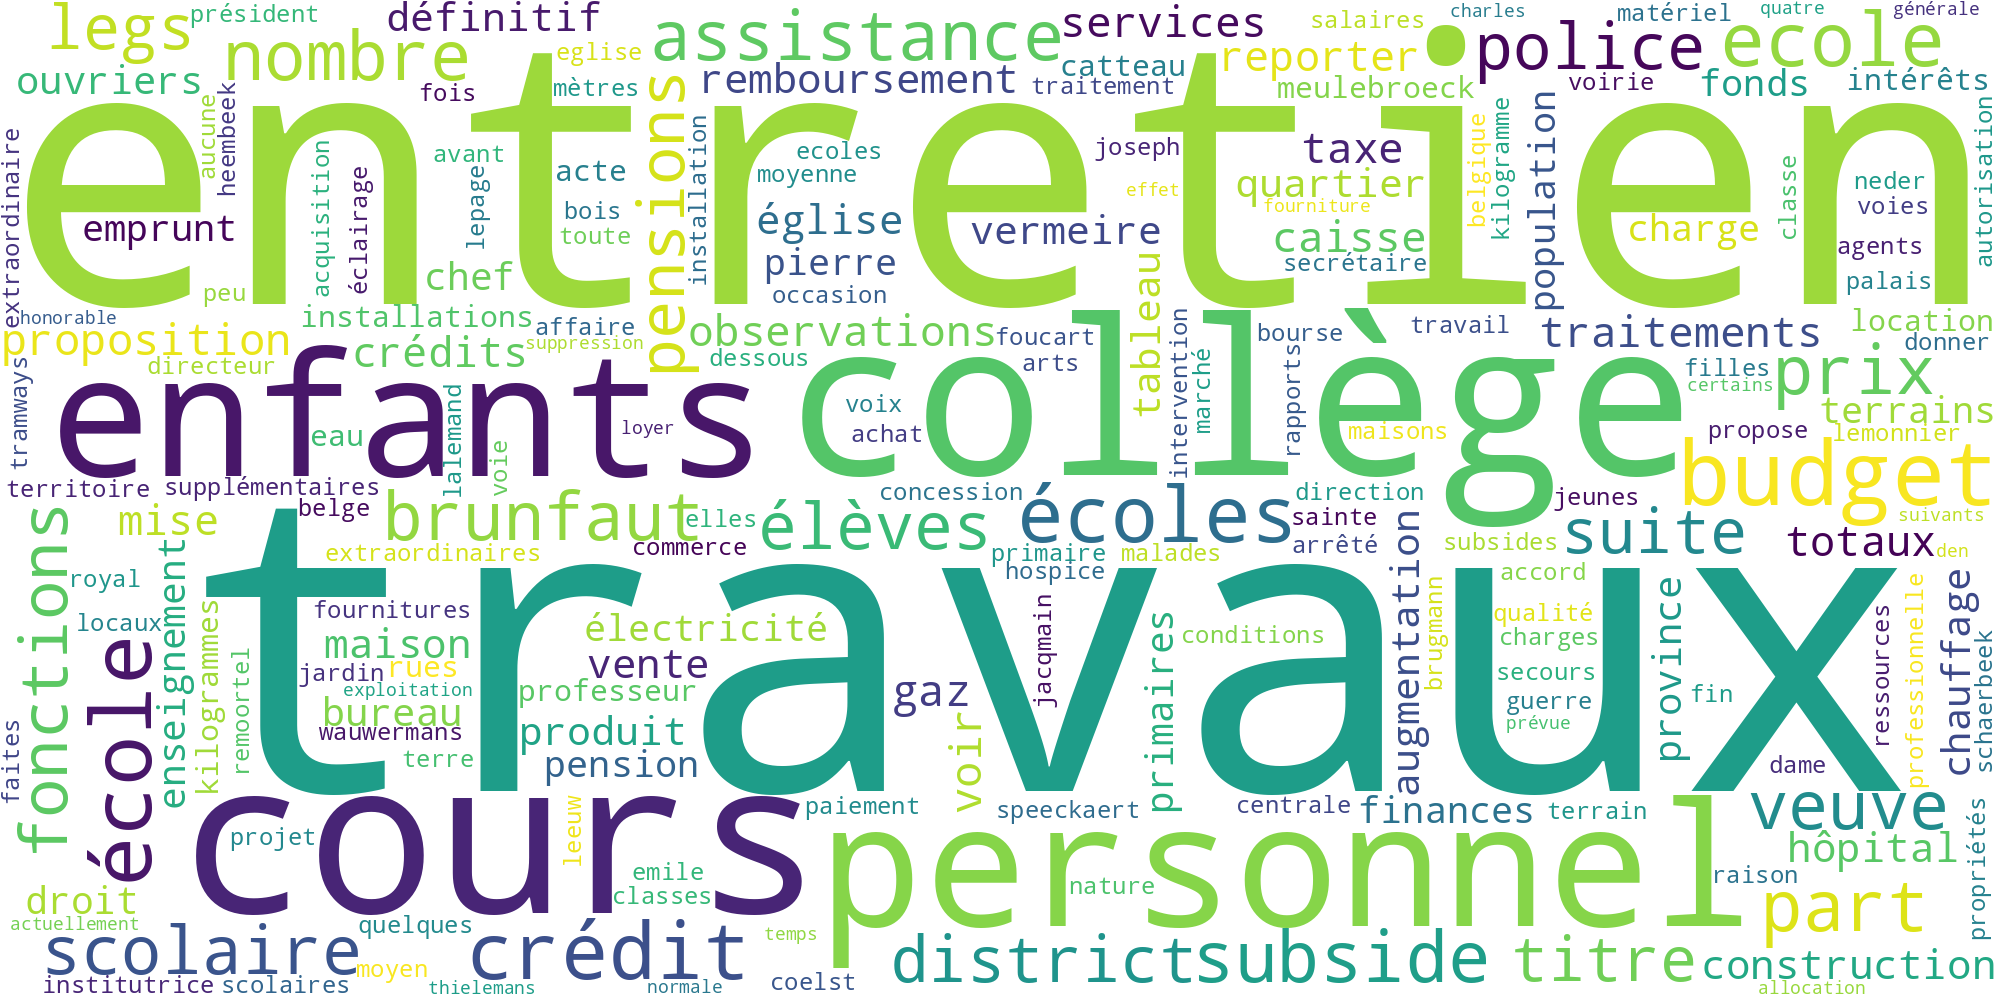

In [50]:
cloud = WordCloud(width=2000, height=1000, background_color='white').generate_from_frequencies(frequencies)
cloud.to_file(os.path.join(f"../data/{selected_year}.png"))
Image(filename=os.path.join(f"../data/{selected_year}.png"))

#### Retrait du thème de l'école, du budget (trop général) et autres

In [51]:
sw += ["collège", "école", "ecole", "écoles", "cours", "totaux", "budget", "part", "proposition", "nombre", "émettre", "voir", "suite", "rues", "fonction", "fonctions", 
       "défintif", "mise", "certains", "certain", "faites", "elles", "enfants", "enfant"]

print(sorted(set(sw)))

['administration', 'agit', 'ai', 'aie', 'aient', 'aies', 'ainsi', 'ait', 'an', 'ancien', 'ancienne', 'année', 'années', 'ans', 'août', 'appel', 'approbation', 'après', 'arreté', 'arrêtéarrêtés', 'art', 'article', 'articles', 'as', 'assitances', 'au', 'aura', 'aurai', 'auraient', 'aurais', 'aurait', 'auras', 'aurez', 'auriez', 'aurions', 'aurons', 'auront', 'aussi', 'autre', 'autres', 'aux', 'avaient', 'avais', 'avait', 'avec', 'avenue', 'avez', 'aviez', 'avions', 'avis', 'avoir', 'avons', 'avril', 'ayant', 'ayante', 'ayantes', 'ayants', 'ayez', 'ayons', 'bien', 'boulevard', 'bourgmestre', 'bruxelles', 'bruxellois', 'budget', 'c', 'cas', 'ce', 'cela', 'celle', 'celles', 'celui', 'certain', 'certains', 'ces', 'cet', 'cette', 'ceux', 'chacun', 'chacune', 'chaque', 'collège', 'comite', 'comité', 'comme', 'commission', 'communal', 'communale', 'communales', 'communaux', 'commune', 'communes', 'compte', 'concerne', 'conseil', 'considérant', 'contre', 'cours', 'crois', 'd', 'dans', 'date', 'd

In [52]:
sample = [w for w in sample if w not in sw]
voc = set(sample)
print(f"{len(sample)} words kept ({len(voc)} different word forms)")

193626 words kept (24855 different word forms)


In [53]:
def reduced_text(selected_year):
    input_path = f"../data/{selected_year}.txt"
    output_path = f"../data/{selected_year}_reduced.txt"
    output = open(output_path, "w", encoding='utf-8')
    with open(input_path, encoding='utf-8') as f:
        text = f.read()
        words = nltk.wordpunct_tokenize(text)
        kept = [w.lower() for w in words if len(w) > 2 and w.isalpha() and w.lower() not in sw]
        kept_string = " ".join(kept)
        output.write(kept_string)
    return f'Output has been written in {output_path}!'

In [54]:
reduced_text(selected_year)

'Output has been written in ../data/1930_reduced.txt!'

In [55]:
text_reduced = open(os.path.join(f'../data/{selected_year}_reduced.txt'), 'r').read()
frequencies = Counter(text_reduced.split())

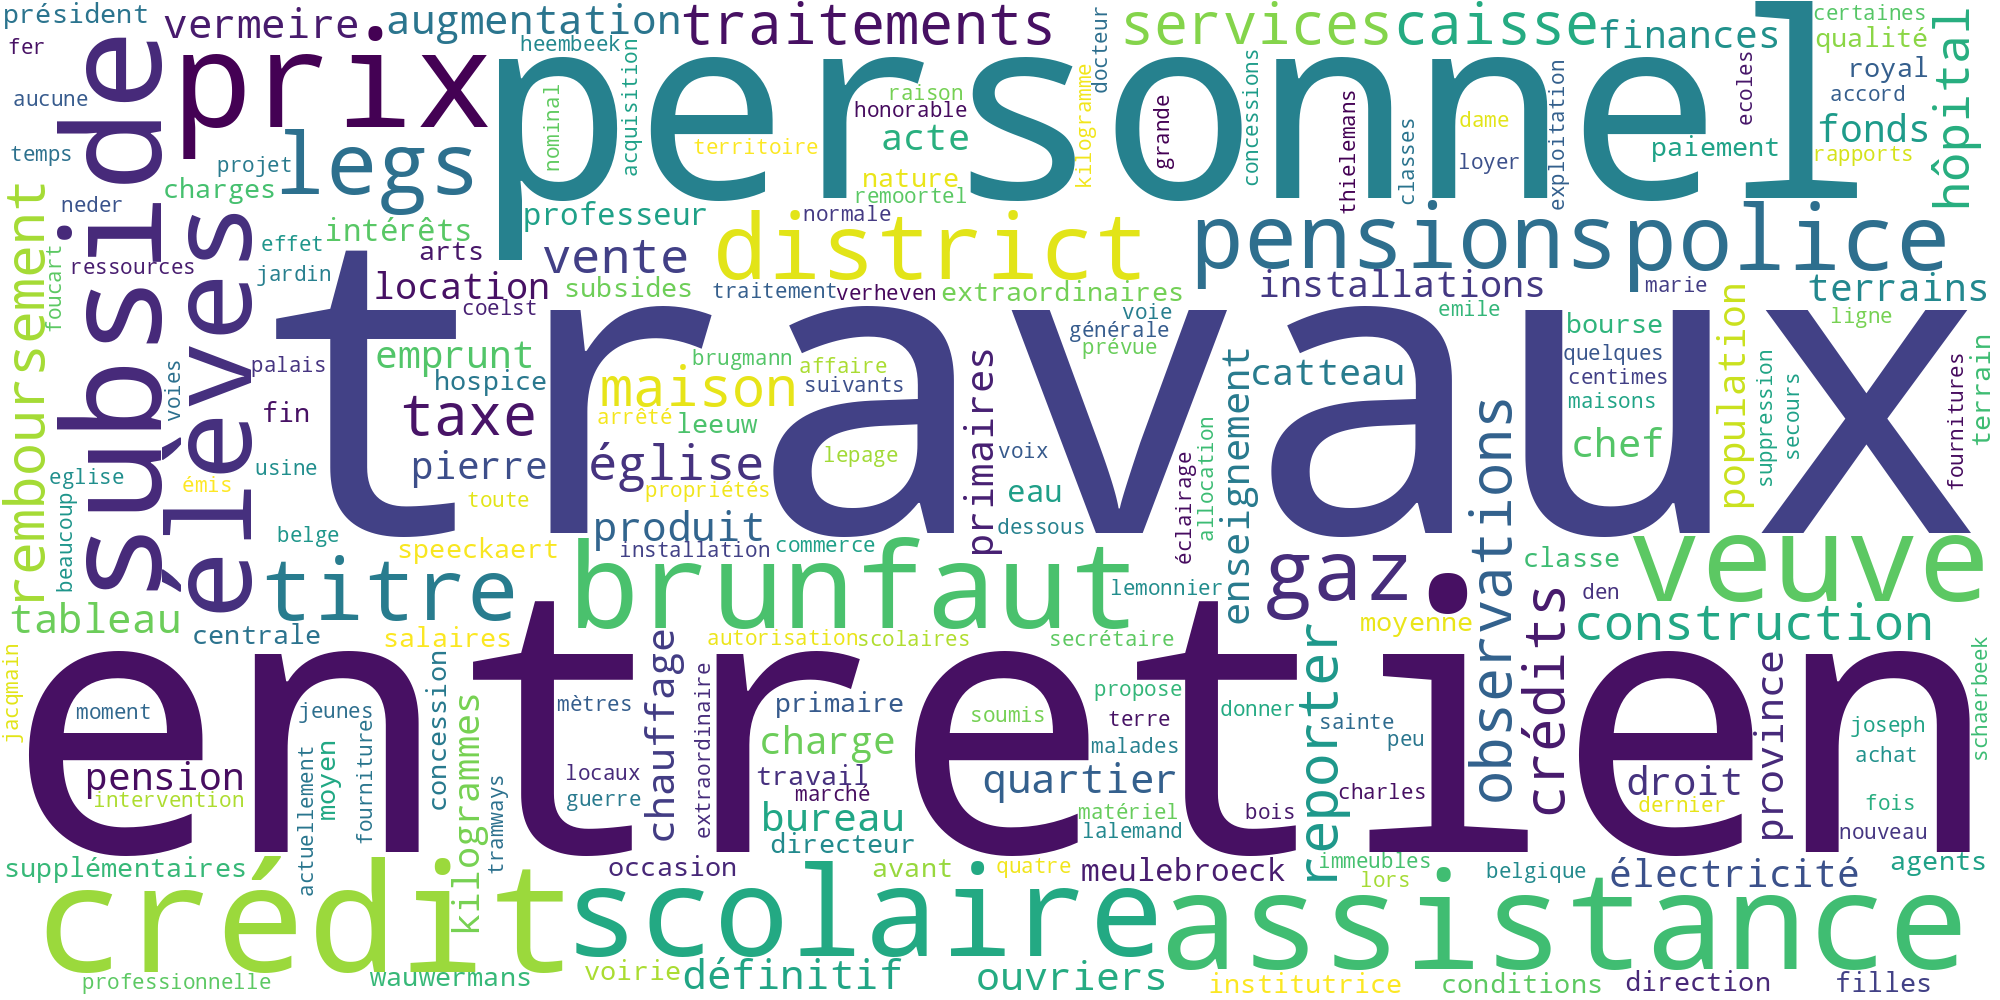

In [56]:
cloud = WordCloud(width=2000, height=1000, background_color='white').generate_from_frequencies(frequencies)
cloud.to_file(os.path.join(f"../data/{selected_year}.png"))
Image(filename=os.path.join(f"../data/{selected_year}.png"))

In [57]:
sw_temp += sw

In [58]:
def reduced_text(selected_year):
    input_path = f"../data/{selected_year}.txt"
    output_path = f"../data/{selected_year}_reduced2.txt"
    output = open(output_path, "w", encoding='utf-8')
    with open(input_path, encoding='utf-8') as f:
        text = f.read()
        words = nltk.wordpunct_tokenize(text)
        kept = [w.lower() for w in words if len(w) > 2 and w.isalpha() and w.lower() not in sw_temp]
        kept_string = " ".join(kept)
        output.write(kept_string)
    return f'Output has been written in {output_path}!'

In [59]:
reduced_text(selected_year)

'Output has been written in ../data/1930_reduced2.txt!'

In [60]:
text_reduced = open(os.path.join(f'../data/{selected_year}_reduced2.txt'), 'r').read()
frequencies = Counter(text_reduced.split())

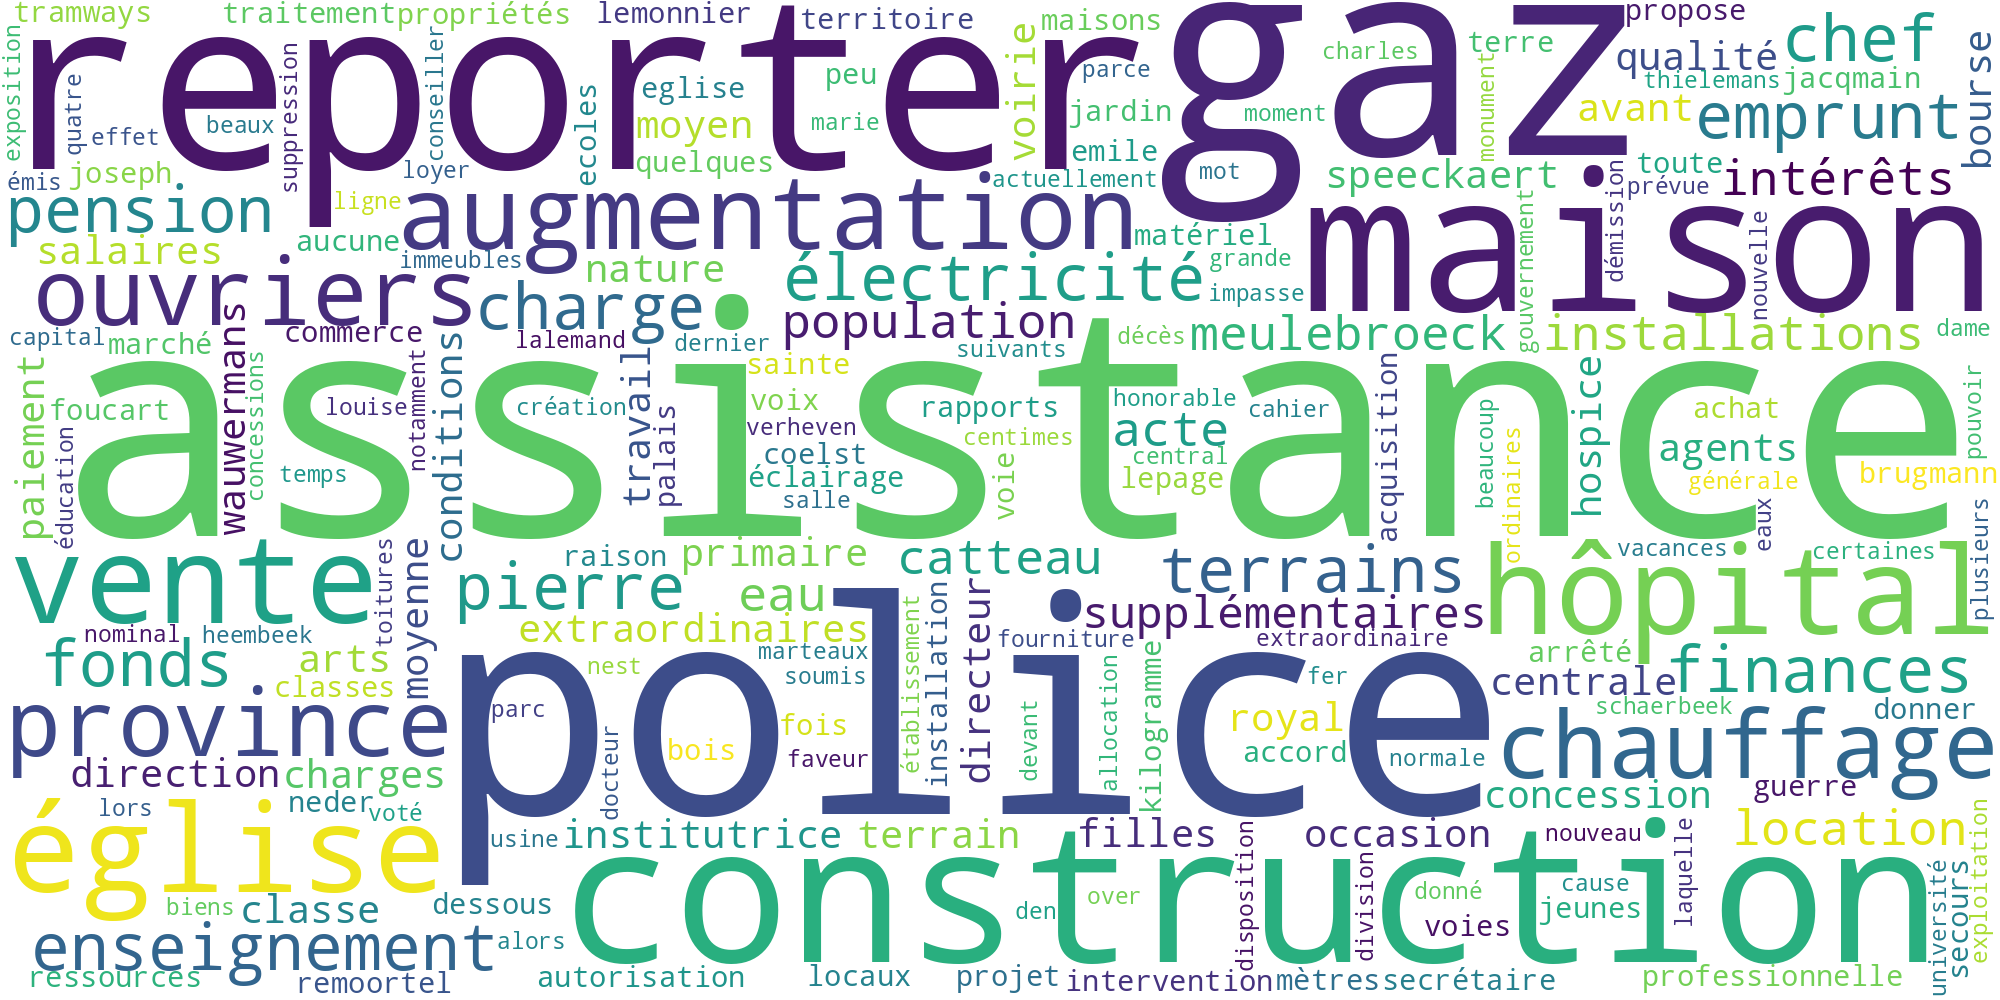

In [61]:
cloud = WordCloud(width=2000, height=1000, background_color='white').generate_from_frequencies(frequencies)
cloud.to_file(os.path.join(f"../data/{selected_year}.png"))
Image(filename=os.path.join(f"../data/{selected_year}.png"))

### Enrichissement de la liste des stopwords

## 3. Named Entity Recognition

In [62]:
nlp = spacy.load('fr_core_news_md')

In [63]:
!wc -m ../data/{selected_year}.txt

4474200 ../data/1930.txt


In [64]:
text = open(f"../data/{selected_year}_clean.txt", encoding='utf-8').read()[:1000000]

In [65]:
%%time

doc = nlp(text)

CPU times: user 1min 15s, sys: 1.93 s, total: 1min 17s
Wall time: 1min 17s


In [66]:
people = defaultdict(int)
locations = defaultdict(int)
orgs = defaultdict(int)

personne = []
location = []
organisation = []

for ent in doc.ents:
    if ent.label_ == "PER" and len(ent.text) > 3:
        people[ent.text] += 1
        personne.append(ent)
    if ent.label_ == "LOC" and len(ent.text) > 3:
        locations[ent.text] += 1
        location.append(ent)
    if ent.label_ == "ORG" and len(ent.text) > 3:
        orgs[ent.text] += 1
        organisation.append(ent)

In [67]:
text = open(f"../data/{selected_year}_clean.txt", encoding='utf-8').read()[1000000:2000000]

doc = nlp(text)
for ent in doc.ents:
    if ent.label_ == "PER" and len(ent.text) > 3:
        people[ent.text] += 1
        personne.append(ent)
    if ent.label_ == "LOC" and len(ent.text) > 3:
        locations[ent.text] += 1
        location.append(ent)
    if ent.label_ == "ORG" and len(ent.text) > 3:
        orgs[ent.text] += 1
        organisation.append(ent)

In [68]:
text = open(f"../data/{selected_year}_clean.txt", encoding='utf-8').read()[2000000:3000000]

doc = nlp(text)
for ent in doc.ents:
    if ent.label_ == "PER" and len(ent.text) > 3:
        people[ent.text] += 1
        personne.append(ent)
    if ent.label_ == "LOC" and len(ent.text) > 3:
        locations[ent.text] += 1
        location.append(ent)
    if ent.label_ == "ORG" and len(ent.text) > 3:
        orgs[ent.text] += 1
        organisation.append(ent)

In [69]:
text = open(f"../data/{selected_year}_clean.txt", encoding='utf-8').read()[3000000:4000000]

doc = nlp(text)
for ent in doc.ents:
    if ent.label_ == "PER" and len(ent.text) > 3:
        people[ent.text] += 1
        personne.append(ent)
    if ent.label_ == "LOC" and len(ent.text) > 3:
        locations[ent.text] += 1
        location.append(ent)
    if ent.label_ == "ORG" and len(ent.text) > 3:
        orgs[ent.text] += 1
        organisation.append(ent)

In [70]:
text = open(f"../data/{selected_year}_clean.txt", encoding='utf-8').read()[4000000:]

doc = nlp(text)
for ent in doc.ents:
    if ent.label_ == "PER" and len(ent.text) > 3:
        people[ent.text] += 1
        personne.append(ent)
    if ent.label_ == "LOC" and len(ent.text) > 3:
        locations[ent.text] += 1
        location.append(ent)
    if ent.label_ == "ORG" and len(ent.text) > 3:
        orgs[ent.text] += 1
        organisation.append(ent)

In [71]:
print(f"Il existe {len(set(personne))} personnes, {len(set(location))} localisations et {len(set(organisation))} organisations différentes dans le corpus")
print(sorted(set(organisation)))

Il existe 5050 personnes, 860 localisations et 189 organisations différentes dans le corpus
[utibis, beneden, institut hautes, dei nominations, allocath, schaerbeek cerisiers, ucde, hem nct, anderlecht lavage linge, schaerbeek toitures, eui justification, académie royale beaux arts arts décoratifs généraux chauffage, sainteelisabeth, france allemagne, université travail hainaut, oftice valeurs mobilières, ghamp, bibliothèque populaire ligue ouvrière, université arts métiers vécole professionnelle serrurerie poêlerie, université arts vécole, université arts métiers vécole professionnelle, anderlecht etterbeek molenbeeksaint jean schaerbeek, front ravenstein, sterrebeek, sterrebeek, haren neder over heembeek faubourg molenbeek canalisations nouvelles artères putterie canalisations nouvelles solbosch, sto ors tri xeiiesj fédération fédération typographique galvanoplastes sect algemeene anvers belges, léopold laboratoire laiterie bois, crombez, serève caty, gilles physiologie anatomie inst

In [72]:
sorted_people = sorted(people.items(), key=lambda kv: kv[1], reverse=True)
sorted_locations = sorted(locations.items(), key=lambda kv: kv[1], reverse=True)
sorted_orgs = sorted(orgs.items(), key=lambda kv: kv[1], reverse=True)

for person, freq in sorted_people[:10]:
    print(f"{person} apparait {freq} fois dans le corpus")
for loc, freq in sorted_locations[:10]:
    print(f"{loc} apparait {freq} fois dans le corpus")
for org, freq in sorted_orgs[:10]:
    print(f"{org} apparait {freq} fois dans le corpus")

echevin apparait 62 fois dans le corpus
foucart apparait 56 fois dans le corpus
echevin meulebroeck apparait 53 fois dans le corpus
remoortel apparait 48 fois dans le corpus
speeckaert apparait 39 fois dans le corpus
verheven apparait 38 fois dans le corpus
charles buis apparait 36 fois dans le corpus
anspach apparait 33 fois dans le corpus
echevin coelst apparait 32 fois dans le corpus
sablon apparait 28 fois dans le corpus
schaerbeek apparait 49 fois dans le corpus
remoortel apparait 26 fois dans le corpus
paris apparait 21 fois dans le corpus
laeken apparait 16 fois dans le corpus
vilvorde apparait 14 fois dans le corpus
anderlecht apparait 14 fois dans le corpus
france apparait 9 fois dans le corpus
hollebeek apparait 9 fois dans le corpus
luxembourg apparait 9 fois dans le corpus
boulevard emile bockstael apparait 9 fois dans le corpus
osseghem apparait 3 fois dans le corpus
den nest apparait 3 fois dans le corpus
ford apparait 3 fois dans le corpus
université michigan apparait 2 

## 4. Sentiment analysis

In [73]:
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

def get_sentiment(input_text):
    blob = tb(input_text)
    polarity, subjectivity = blob.sentiment
    polarity_perc = f"{100*abs(polarity):.0f}"
    subjectivity_perc = f"{100*subjectivity:.0f}"
    if polarity > 0:
        polarity_str = f"{polarity_perc}% positive"
    elif polarity < 0:
        polarity_str = f"{polarity_perc}% negative"
    else:
        polarity_str = "neutral"
    if subjectivity > 0:
        subjectivity_str = f"{subjectivity_perc}% subjective"
    else:
        subjectivity_str = "perfectly objective"
    print(f"This text is {polarity_str} and {subjectivity_str}.")

In [74]:
get_sentiment("M. Lalemand. Encore une victime de la roulette !")

This text is neutral and perfectly objective.


In [75]:
get_sentiment("Elle ne sera que de courte durée. Mais il n'est pas trop tôt pour dire à notre excellent collègue toute la gratitude que nous lui devons pour le dévouement sans limite" 
              "qu'il n'a jamais cessé d'apporter dans l'accomplissement de sa tâche. Il l'a remplie en homme de cœur. Et il recueille la plus douce des récompenses : "
              "l'amour que lui vouent les enfants de nos écoles, conquis par sa bonté et qu'il entoura toujours d'une sollicitude vraiment paternelle.")

This text is 12% positive and 38% subjective.


In [76]:
get_sentiment("Ce n'est pas sans émotion que je vois s'interrompre par le congé que va prendre M . Jacqmain, une collaboration dont, pendant vingt et une années, j'ai pu apprécier tout le prix")

This text is 1% positive and 5% subjective.


In [77]:
get_sentiment("Mesdames et Messieurs, permettez au doyen d'âge et de siège de cette assemblée de s'associer aux paroles que l'honorable Bourgmestre vient d'adresser à notre collègue et ami, M . Jacqmain.")

This text is 62% positive and 72% subjective.


In [78]:
get_sentiment("Je vous donne aete dé votre prestation de serment et vous déclara installe dans vos fonctions d'échevin. Je suis heureux de vous voir reprendre, au banc du Collège, la place que vous y avez occupée du 30 mai au 15 avril avec tant d'autorité et de distinction.")

This text is 30% positive and 45% subjective.


In [79]:
get_sentiment("Les services que vous nous avez rendus sont garants de ceux que nous attendons encore de vous.")

This text is neutral and perfectly objective.


In [80]:
get_sentiment("Ils justifient pleinement le nouveau témoignage de confiance que vient de vous donner le Conseil communal.")

This text is 34% positive and 25% subjective.


In [81]:
get_sentiment("Je vous prie, Monsieur l'Echevin, de vouloir prendre place au banc du Collège.")

This text is neutral and perfectly objective.


In [82]:
get_sentiment("Je remercie M. le Bourgmestre de ce qu'il vient de dire et mes collègues de l'accueil qu'ils ont réservé à ses paroles. Succédant à M . l'Echevin Jacqmain, je m'inspirerai de son exemple et de celui de ses prédécesseurs, et j'espère mériter votre confiance et votre approbation.")

This text is 5% negative and perfectly objective.


In [83]:
get_sentiment("Et maintenant, pour terminer, permettez-moi, pour justifier plus encore notre opposition à vos propositions de relèvement excessif de votre tarif, de citer comment nous comprenons les tarifs différentiels sollicités si souvent par nous.")

This text is 5% negative and 43% subjective.


In [84]:
get_sentiment("La tarification en électricité est fonction de l a durée d'utilisation du courant, ainsi que du moment auquel l'emploi est effectué. Ceci admis, divers tarifs s'imposent ; nous en avons une application au service d'électricité de la Ville de Gand.")

This text is 5% positive and 15% subjective.


### Commentaires

L'ajout de mots aux listes à ignorer est délicat. Il faudrait affiner la méthode, car bien qu'elle fasse émerger certaines problématqiues peu à peu, elle fait l'impasse sur la rigueur de la sélection des mots à garder, explorer, ou à l'inverse, à écarter puisqu'ils reviennent de manière fréquente et n'appporte pas beaucoup d'informations.